# Импортируем библиотеки.

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import TimeSeriesSplit

sns.set(rc={'figure.figsize':(20,10)})

# Загружаем данные, правим датафрейм и визуализируем данные.

In [12]:
df = pd.read_csv('ВС DS Сбер data.csv', delimiter = ';')

df.columns = ['Report date', 'Value']

df['Report date'] = pd.to_datetime(df['Report date'], infer_datetime_format = True)
df.set_index('Report date', inplace = True)

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

df.sample(10)

,Value,Year,Month,Day
Report date,,,,
2018-08-27,46600664592,2018,8,27
2018-06-11,57341252123,2018,6,11
2019-09-21,63202473102,2019,9,21
2016-06-13,28483526641,2016,6,13
2018-07-17,53200941029,2018,7,17
2016-03-03,19580839021,2016,3,3
2014-03-02,5010720003,2014,3,2
2017-03-16,33197736699,2017,3,16
2015-03-05,14301237455,2015,3,5


<AxesSubplot:xlabel='Report date', ylabel='Value'>

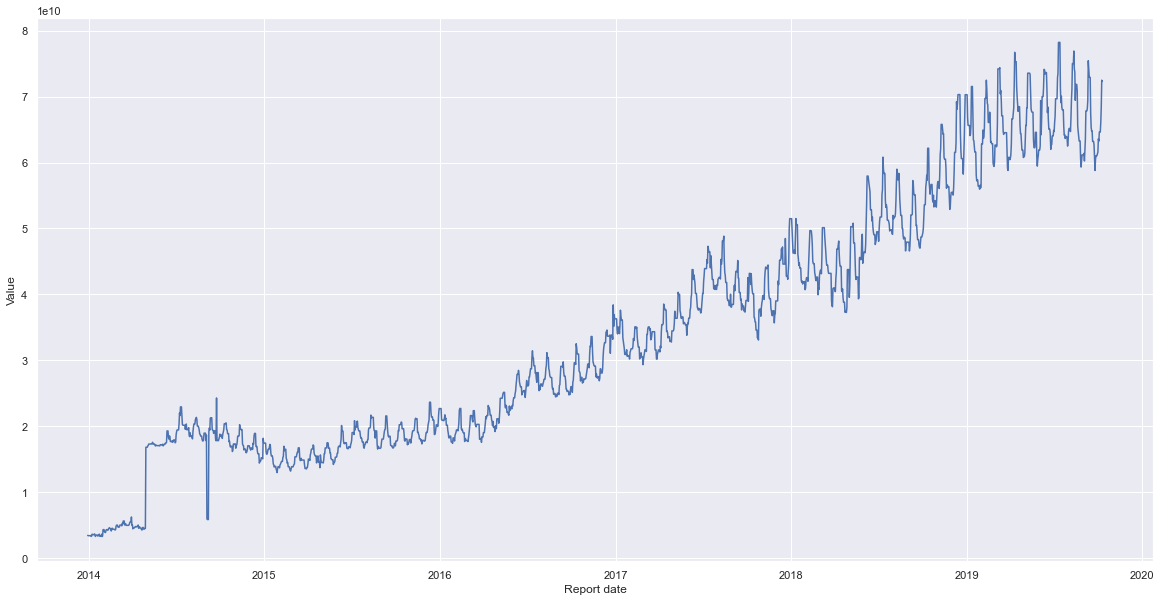

In [13]:
sns.lineplot(df['Value'])

# Присваивем значения x и y.

In [14]:
x = df.drop('Value', axis = 1)
y = df['Value']

# Используем квантильную регрессию.

In [ ]:
#Quantiles = .5, .95

model = QuantileRegressor(quantile = .5)
model.fit(x, y)